# Project 2 - Analyzing the NYC Subway Dataset
'''
Created by Laura Uzcategui 
Date : 30 Sept 2015 

Modified: 
Iteration 1 - 17 Oct 2015 - Changes to Hypothesis, Plots labeling and Conclusions.
'''


# Subway Ridership 

Subway ridership consists of all passengers (other than NYC Transit employees) who enter the subway system, including passengers who transfer from buses.  Ridership does not include passengers who exit the subway or passengers who transfer from other subway lines, with the exception of out-of-system transfers; e.g., between the Lexington Av/63 St F subwaystation and the Lexington Avenue N subwayQ subwayR subway/59 St4 subway5 subway6 subwaystation, where customers use their MetroCard to make the transfer.

This project has the purpose to analyze and investigate if more people ride the Subway when is raining vs when it is not raining. [1]

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


<bound method Figure.show of <matplotlib.figure.Figure object at 0x7f9851509210>>

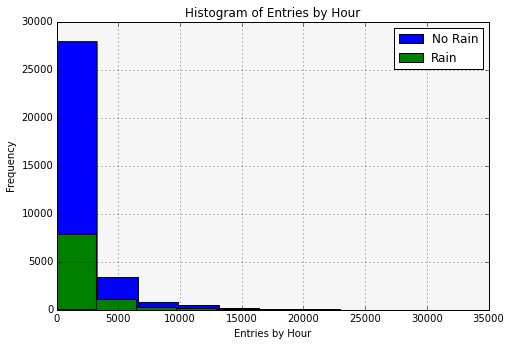

In [9]:
# making available graphs inline
%pylab inline
%matplotlib inline  
# importing pandas for manipulation of data
import pandas as pd
# importing matplotlib for printing the plot
import matplotlib.pyplot as plt

# Importing scipy for working with Mann-Whitney U-Test
import scipy
import scipy.stats

#Importing numpy and statsmodels for Linear Regression 
import numpy as np
import statsmodels.api as sm
import sys

# calculus for Gradient Descent
from sklearn.linear_model import SGDRegressor

from ggplot import *

# Loading the path of our NYC subway dataset
filename = './turnstile_weather_v2.csv'

# Let's read our dataset
weather_data = pd.read_csv(filename)


def entries_histogram(turnstile_weather):
      
    fig = plt.figure()
    
    left, width = 1,1
    rect1 = [left, 1, width, 1]
    axescolor  = '#f6f6f6'  # the axes background color
    ax1 = fig.add_axes(rect1, axisbg=axescolor)  #left, bottom, width, height
    ax1.set_title('Histogram of Entries by Hour') # title of the plota
    ax1.set_xlabel('Entries by Hour')
    ax1.set_ylabel('Frequency')
    
    #Blue Bars - NO Rain
    turnstile_weather[turnstile_weather.rain==0].ENTRIESn_hourly.hist(label='No Rain') # your code here to plot a historgram for hourly entries when it is not raining (GREEN)
    #Green Bars - Raining
    turnstile_weather[turnstile_weather.rain==1].ENTRIESn_hourly.hist(label='Rain') # your code here to plot a historgram for hourly entries when it is raining (BLUE)
    plt.legend()
    return fig

entries_histogram(weather_data).show

Insight : Both Histograms does not seems to follow a Normal Distribution. 

##Section 1. Statistical Test 

####1.1 Which statistical test did you use to Analyze the NYC Subway data?
 
  The statistical test used for Analyze NYC Subway data is Mann Whitney U Test. 
 
#### Did you use a one-tail or a two-tail P Value ? 
  
   The P value used is Two Tail Test. 
  

#### What is the null hypothesis ? 

The appropiate hypothesis for this task will be the following: 
* H0 ( Null hypothesis) : $ P( Rain  >  No Rain ) = 0.5 $ 
Probability that Riderships with Rain is larger 

* H1 ( Alternative hypothises) : $ P( Rain  >  No Rain )  \ne 0.5 $ 

#### What is your p-critical value? 

 The p-critical value will be 0.05 since is two-sided Test, each side will be 0.025
 
#### 1.2 Why is this statistical test applicable to the dataset? 
  
 Based on the visualisation for the Histograms, the distributions do not seems to be Normal and based on the assumption We draw the data from unknown distributions We could apply Mann-Whitney U Test.
 

In [10]:
def mann_whitney_plus_means(turnstile_weather):
  
    entries_rain = turnstile_weather[turnstile_weather.rain==1].ENTRIESn_hourly
    entries_norain = turnstile_weather[turnstile_weather.rain==0].ENTRIESn_hourly

    with_rain_mean = np.mean(entries_rain)
    without_rain_mean = np.mean(entries_norain)
    U, p = scipy.stats.mannwhitneyu(entries_rain,entries_norain)
    
    return with_rain_mean, without_rain_mean, U, p*2 # leave this line for the grader


In [11]:
print mann_whitney_plus_means(weather_data)

(2028.1960354720918, 1845.5394386644084, 153635120.5, 5.4821391424874991e-06)


#### 1.3 What results did you get from this statistical test ? 
 
 A Mann-Whitney  U Test indicated that Ridership when is Raining (Mean = 2028.1960354720918) was statiscally significant different than Ridership when is not Raining (Mean = 1845.5394386644084), U =153635120.5, p=5.48213e-06
 
 [2]
 
####1.4 What is the significance and interpretation of these results?
 We reject the null hypothesis since the results are statically significant different and it falls within the critical region then We could infere that Rain might not affect ridership but has to be studied in deep as will be done now proceeding with Linear Regression Study.

##Section 2. Linear Regression.

####2.1 What approach did you use to compute the coefficients theta and produce prediction for ENTRIESn_hourly in your regression model:
    
  The approach used for compute coefficients and prediction were : OLS and Gradient Descent
    
####2.2 What features (input variables) did you use in your model? Did you use any dummy variables as part of your features?

    hour - Hour of the timestamp from TIMEn
    rain - Indicator (0 or 1) if rain occurred within the calendar day at the location.    
    weekday - Indicator (0 or 1) if the date is a weekday (Mon ­ Fri)
    day_week - Integer (0 ­ 6 Mon ­ Sun) corresponding to the day of the week.

     
 As part of the features selected a Dummy variable has been selected. 
     UNIT  - Remote unit that collects turnstile information ( Subway station )
 

####2.3 Why did you select these features in your model? We are looking for specific reasons that lead you to believe that

 The reasons for select the features in the model were: 
    Whenever the weather is different than sunny, such as Windy (wspdi), Rainy(rain) or Foggy(fog), riders always prefer to use Subway since they don't have to drive or use bike for going to work, school or college. 
    Also, It has been selected some features such as rain and means for wind,tempeature,precipitation and pressure. And if it's a weekday on based on the day of the week the values for R squared were improved drastically.


In [12]:
def linear_regression(features, values):
    """
     Linear regression applied with OLS 
    """

    features = sm.add_constant(features)
    
    model = sm.OLS(values,features)
    results = model.fit()
    intercept = results.params[0]
    parameters = results.params[1:]
    print results.summary()
    #print parameters
    return intercept, parameters

def predictions(dataframe):

    features = dataframe[['weekday','day_week','rain']]
    #Adding dummies for UNIT, conds and station
    dummy_units = pd.get_dummies(dataframe['UNIT'], prefix='unit')
    dummy_hour  = pd.get_dummies(dataframe['hour'],prefix='hours')
    
    features = features.join(dummy_units)
    features = features.join(dummy_hour)

    # Values
    values = dataframe['ENTRIESn_hourly']

    # Perform linear regression
    intercept, params = linear_regression(features, values)

    predictions = intercept + np.dot(features, params)
    return predictions


In [13]:
pred =  predictions(weather_data)

                            OLS Regression Results                            
Dep. Variable:        ENTRIESn_hourly   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     202.8
Date:                Sun, 18 Oct 2015   Prob (F-statistic):               0.00
Time:                        01:16:36   Log-Likelihood:            -3.8466e+05
No. Observations:               42649   AIC:                         7.698e+05
Df Residuals:                   42401   BIC:                         7.720e+05
Df Model:                         247                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        577.1033     40.529     14.239      0.0


####2.4 What are the parameters (also known as "coefficients" or "weights") of the non-dummy features in your linear regression model?
 The parameters are the that minimize the least squares criterion for the model. 
 
  Please observe the table below in which the coeffiecients of the non-dummy features can be appreciated.


In [14]:
def compute_r_squared(data, predictions):
    '''data - refers to data points collected
       predictions - based on features selected we calculate 
    '''
    mean_p = np.mean(data) # mean of observations
    sse = np.sum((data-predictions)**2) #sum squared error
    sst = np.sum((data-mean_p)**2) # total sum of squares

    r_squared = 1 - ( sse / sst )
    #print data.shape
    #print predictions.shape
    
    return r_squared

In [15]:
dataPoints = weather_data['ENTRIESn_hourly']
r_squared = compute_r_squared(dataPoints,pred)
print "R-squared = ",r_squared

R-squared =  0.541631441682


####2.5 What is your model’s R2 (coefficients of determination) value?
$ R^2$  = 0.54

####2.6 What does this R2 value mean for the goodness of fit for your regression model? Do you think this linear model to predict ridership is appropriate for this dataset, given this R2  value?

This value seem like a good fit for the model since is superior to 0.40 and closer to 1.


In [16]:
def plot_residuals(turnstile_weather, predictions):
    fig = plt.figure()
    left, width = 1, 1
    rect1 = [left, 1, width, 1]
    axescolor  = '#f6f6f6'  # the axes background color
    ax1 = fig.add_axes(rect1, axisbg=axescolor)  #left, bottom, width, height
    (turnstile_weather['ENTRIESn_hourly'] - predictions).hist(bins=80)
    ax1.set_title('Residuals of Entries by Hour vs. Predictions') # title of the plota
    ax1.set_xlabel('Difference Entries by Hour & Predictions')
    ax1.set_ylabel('Frequency')
    return fig

Figure(480x320)


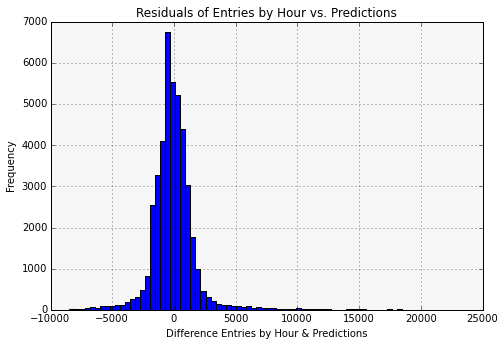

In [17]:
print plot_residuals(weather_data,pred)

x.x Residuals plot

This plot looks like a normal distribution with mean = 0 and by having a peek and long tails that might indicated us to do further transformations to the dataset and check if the regression behaved slighlty better and of course have a better prediction.

### Additional ( Linear regression with Gradient Descent ) 

For exploration of another ways to make the predictions, Linear regression Gradient descent has been applied. 

In [18]:
def normalize_features(features):
    '''
    Returns the means and standard deviations of the given features, along with a normalized feature
    matrix.
    '''
    means = np.mean(features, axis=0)
    std_devs = np.std(features, axis=0)
    normalized_features = (features - means) / std_devs
    return means, std_devs, normalized_features

def recover_params(means, std_devs, norm_intercept, norm_params):
    '''
    Recovers the weights for a linear model given parameters that were fitted using
    normalized features. Takes the means and standard deviations of the original
    features, along with the intercept and parameters computed using the normalized
    features, and returns the intercept and parameters that correspond to the original
    features.
    '''
    intercept = norm_intercept - np.sum(means * norm_params / std_devs)
    params = norm_params / std_devs
    return intercept, params

def linear_regression(features, values):
    """
    Perform linear regression given a data set with an arbitrary number of features.
    """
    clf = SGDRegressor(n_iter=1500)
    clf.fit(features, values)
    intercept = clf.intercept_
    params = clf.coef_
 
    return intercept, params

def predictions(dataframe):
    '''
    Let's predict the ridership of cthe NYC subway using linear regression with gradient descent.
    '''
    
    features = dataframe[['weekday','day_week','rain']]
    #Adding dummies for UNIT, conds and station
    dummy_units = pd.get_dummies(dataframe['UNIT'], prefix='unit')
    dummy_hour  = pd.get_dummies(dataframe['hour'],prefix='hours')
    
    features = features.join(dummy_units)
    features = features.join(dummy_hour)
    
    # Values
    values = dataframe['ENTRIESn_hourly']

    # Get numpy arrays
    features_array = features.values
    values_array = values.values

    means, std_devs, normalized_features_array = normalize_features(features_array)

    # Perform gradient descent
    norm_intercept, norm_params = linear_regression(normalized_features_array, values_array)

    intercept, params = recover_params(means, std_devs, norm_intercept, norm_params)

    predictions = intercept + np.dot(features_array, params)

    return predictions


In [19]:
#get predictions from gradient descent 
pred_gd = predictions(weather_data)

#calculate r-squared for Gradient descent predictions 
r_squared = compute_r_squared(dataPoints,pred_gd)
print "R-squared = ",r_squared


R-squared =  0.536745879871


##Section 3. Visualization




In [20]:
def entries_histogram_rain(turnstile_weather):
    
    r_plot = ggplot(aes(x='ENTRIESn_hourly'), turnstile_weather) + geom_histogram(binwidth=1000, colour = "black",\
                                                                                  fill="blue")
    return r_plot



### 3.1 Histogram of Entries by Hour

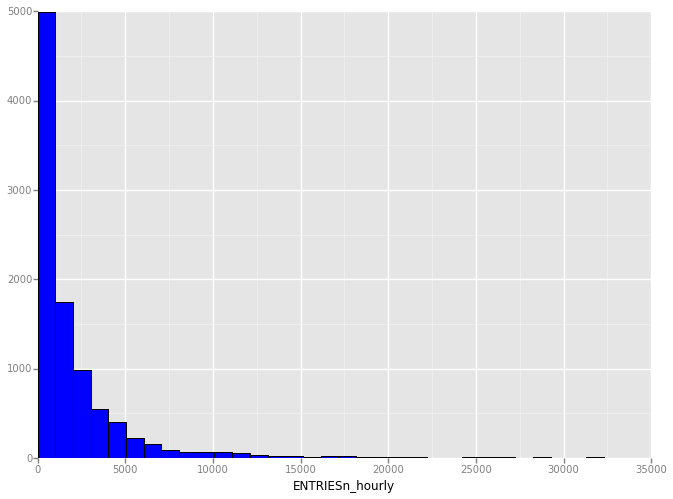

<ggplot: (8768259947013)>


In [22]:
weather_rain = weather_data[weather_data.rain == 1]
print entries_histogram_rain(weather_rain)

In [23]:
def entries_histogram_Norain(turnstile_weather):
      
    r_plot = ggplot(aes(x='ENTRIESn_hourly'), turnstile_weather) + \
    geom_histogram(binwidth=1000,colour = "black", fill="green" )
    return r_plot

weather_Norain = weather_data[weather_data.rain == 0]


### 3.2 Histogram of Entries by Hour

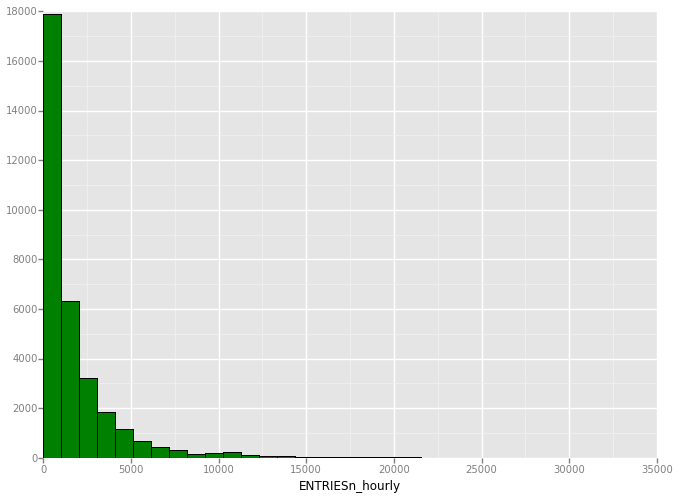

<ggplot: (8768259356393)>


In [24]:
print entries_histogram_Norain(weather_Norain)

#### Insight: This histogram represents the number of Entries by Hour whenever is Raining (Hist 3.1) vs when is not Raining (Hist 3.2), we might infere from the results that Ridership when is not Raining is superior from when is Raining.

In [95]:
def plot_weather_data(turnstile_weather):

    
    label_list = ['Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    
    pd.options.mode.chained_assignment = None

    g = turnstile_weather.groupby(['hour','day_week']).sum().reset_index()
    pplot = ggplot(g, aes('day_week', 'ENTRIESn_hourly',color='hour')) + geom_line() \
    + labs(title="Entries by Hour and Day of Week", x = "Day of the Week", y = "Entries") \
    + scale_x_discrete(labels=label_list) 
    

    return pplot

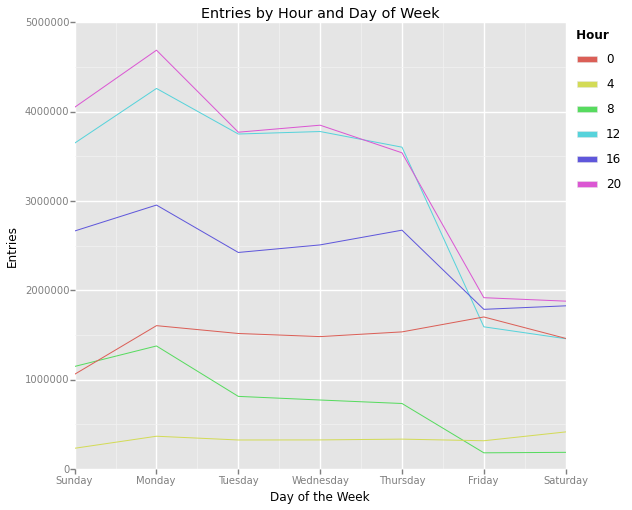

<ggplot: (8768259861945)>


In [96]:
print plot_weather_data(weather_data)

### Visualisation of Ridership by Hour and Day of Week.

#### Insight: based on the visualisation it can be infered tha: 
    Ridership is higher at night on Mondays (8pm)
    Within the progress of the week Riderships are falling
    Over 4am ridership is almost constant and lower 
    Riderships at mornings (8am) are higher at the beggining of the week
    

## Section 4. Conclusion

####4.1 From your analysis and interpretation of the data, do more people ride the NYC subway when it is raining or when it is not raining?  

 Based on the analysis and interpretation of the data, more people ride the NYC when is not raining. 

####4.2 What analysis lead you to this conclusion? You should use results from both your statistical tests and your linear regression to support your analysis.


 

## Section 5. Reflection

####5.1 Please discuss potential shortcomings of the methods of your analysis, including:
    Dataset: the dataset could be improved by wrangling the data for values such as day_week and filling or excluding empty values for rows were weigths were bigger. 
    Analysis: this project has been analysed carefully, nevertheless it could be improved by checking and adjusting multiple combinations of features.
####5.2 (Optional) Do you have any other insight about the dataset that you would like to share with us?

The dataset shared was understandable,  but I believe it could be better if from the beginning students will manipulated the improved dataset.

### References. 

[1]  Metropolitan Transportation Authority's (MTA) (http://web.mta.info/nyct/facts/ridership/)

[2]  Reporting Mann Whitney U Test APA (http://www.slideshare.net/plummer48/reporting-mann-whitney-u-test-in-apa)
